# Finite difference method to solve the Black-Scholes PDE

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm

The Black-Scholes PDE for option pricing is

$$
C_t + \frac12 \sigma^2S^2 C_{SS} + rSC_S - rC = 0
$$

After making $t = T-t$ (time to maturity), so that $C_t = -C_t$, the PDE becomes

$$
C_t = \frac12 \sigma^2S^2 C_{SS} + rSC_S - rC
$$

The initial condition is

$$
C(t=0, S) = \max\{S-K, 0\}
$$

The boundary conditions are

$$
C_s = 0, S \to 0
\\
C_s = 1, S \to \infty
$$

These are called the Neumann boundary conditions.

In [2]:
# parameters

r = 0.03   # risk-free rate
K = 100    # strike price
sigma = 0.15 # volatility
T = 1    # time-to-maturity

In [3]:
# plot the analytical solution (Black-Scholes formula)

N = 1000   # "space" discretization (stock price discretization)
S = np.linspace(1, 200, N)   # stock price range
cdf = sp.stats.norm.cdf
pdf = sp.stats.norm.pdf

d1 = (np.log(S/K) + (r + 0.5*sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
C_theo = cdf(d1) * S - cdf(d2) * K * np.exp(-r * T)

Text(0, 0.5, 'option premium, C')

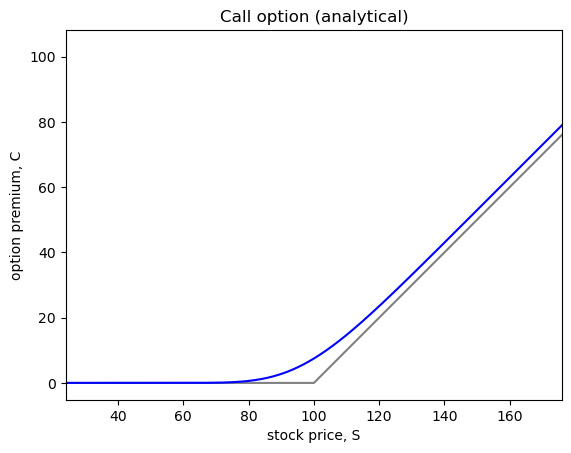

In [4]:
plt.plot(S, np.clip(S - K, a_max=None, a_min=0), 'grey')
plt.plot(S, C_theo, 'b')
plt.axis('equal')
plt.title('Call option (analytical)')
plt.xlim(50, 150)
plt.xlabel('stock price, S')
plt.ylabel('option premium, C')

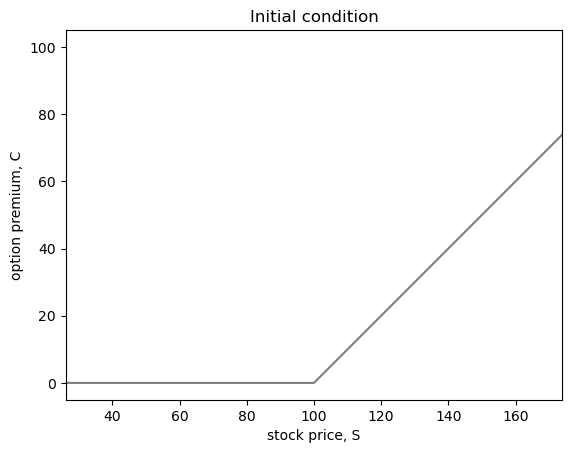

In [11]:
# numerical methods

# t -> T - t
# Ct = σ^2/2 * S^2 * Css + r * S * Cs - r * C
# initial condition C(S, 0) = max(S - K, 0)

dt = 1e-3  # time step = 1/1000 year, ~ 1/4 day
Nt = int(T/dt)  # number of time points
t = np.arange(0, Nt + 1) * dt  # time discretization

C_init = np.clip(S - K, a_max=None, a_min=0)
plt.plot(S, C_init, 'grey')
plt.axis('equal')
plt.title('Initial condition')
plt.xlim(50, 150)
plt.xlabel('stock price, S')
plt.ylabel('option premium, C')

dS = S[1] - S[0]

In [12]:
# implicit Euler method

S_matrix = np.tile(S, (N,1)).T

mat_D2 = np.zeros((N, N))
for i in range(1, N-1):
    mat_D2[i,i-1:i+2] = [1, -2, 1]
    
mat_D1 = np.zeros((N, N))
for i in range(1, N-1):
    mat_D1[i,i-1:i+2] = [-1, 0, 1]

mat = np.zeros((N, N))
mat[1:-1] = (1 + r * dt) * np.eye(N)[1:-1] - dt * sigma**2/2 * (S_matrix[1:-1]**2)/dS**2 * mat_D2[1:-1] - dt * r * S_matrix[1:-1]/(2*dS) * mat_D1[1:-1]

# C1 - C0 = 0
mat[0,0] = -1
mat[0,1] = 1

# C_N - C_N-1 = dS
mat[-1,-2] = -1
mat[-1,-1] = 1

mat = sp.sparse.csr_matrix(mat)

def marching_forward(C_prev):
    b = np.zeros(N)
    b[1:-1] = C_prev[1:-1]
    b[0] = 0
    b[-1] = dS
    C_next = sp.sparse.linalg.spsolve(mat, b)
    return C_next

In [13]:
# test the implicit Euler method

C_list = np.zeros((Nt + 1, N))
C_list[0] = C_init
for i in tqdm(range(1, Nt + 1)):
    C_list[i] = marching_forward(C_list[i-1])

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4244.03it/s]


Text(0, 0.5, 'option premium, C')

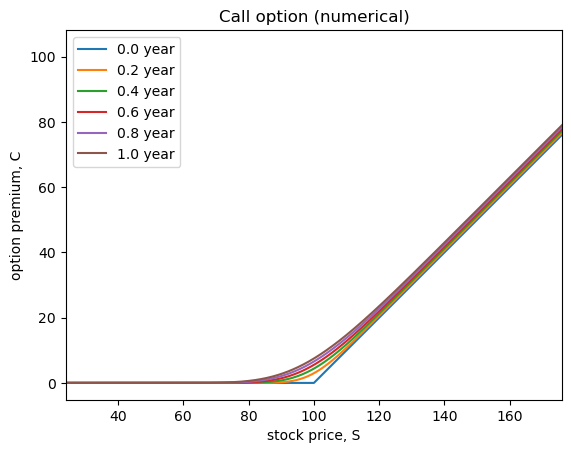

In [14]:
for i in range(0, Nt+1, 200):
    plt.plot(S, C_list[i], label=f'{i*dt/T} year')
plt.legend()
plt.axis('equal')
plt.title('Call option (numerical)')
plt.xlim(50, 150)
plt.xlabel('stock price, S')
plt.ylabel('option premium, C')

Text(0, 0.5, 'numerical error ($)')

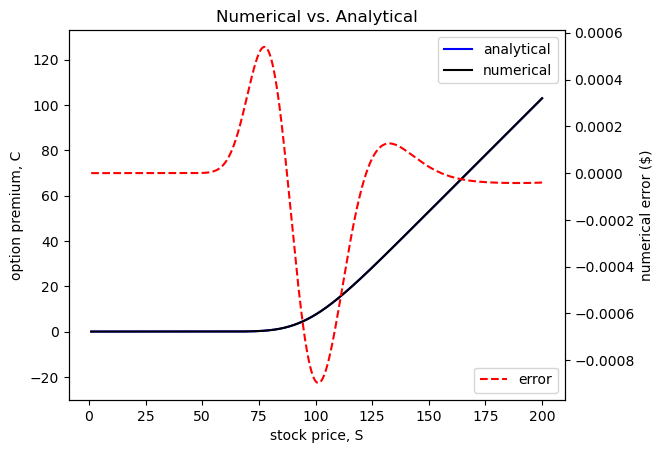

In [15]:
plt.title('Numerical vs. Analytical')
plt.plot(S, C_theo, 'b', label='analytical')
plt.plot(S, C_list[-1], 'k', label='numerical')
plt.legend()
plt.xlabel('stock price, S')
plt.ylabel('option premium, C')
plt.axis('equal')
plt.twinx()
plt.plot(S, C_list[-1] - C_theo, '--r', label='error')
plt.legend(loc=4)
plt.ylabel('numerical error ($)')

Text(0.5, 0, 'option premium, C')

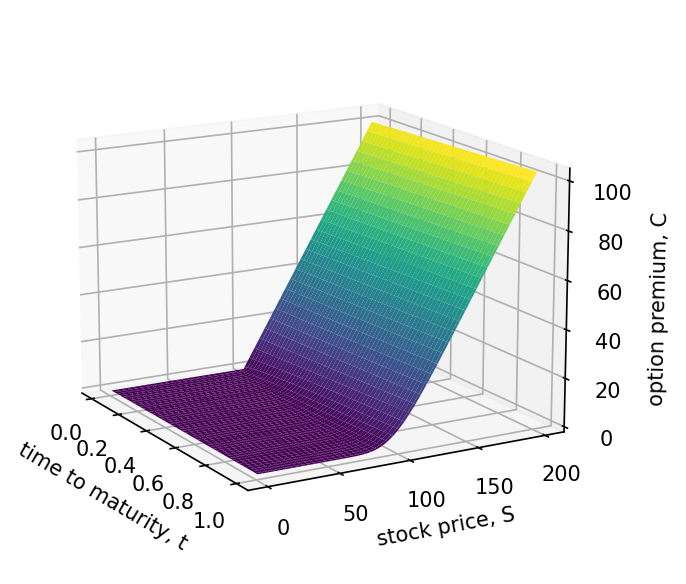

In [19]:
fig = plt.figure(dpi=150)

ax = fig.add_subplot(111, projection='3d')

SS, tt = np.meshgrid(S, t)

surf = ax.plot_surface(tt, SS, C_list, cmap='viridis')

ax.view_init(azim=-30, elev=15)
ax.set_xlabel('time to maturity, t')
ax.set_ylabel('stock price, S')
ax.set_zlabel('option premium, C')